In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict
import itertools

import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import cv2

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

from quinn_embedding_stimuli import *
from quinn_embedding_models import *

In [3]:
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

## Plotting and analysis functions


In [4]:
BATCH_SIZE = 64
    
    
def plot_tsne(tsne_out, target_positions, reference_positions=[], data=None):
    display(Markdown('Plot on the left: colored by the row (vertical position) of the target object'))
    display(Markdown('Plot on the right: colored by the column (horizontal position) of the target object'))
    
    if reference_positions and len(reference_positions) != len(target_positions):
        reference_positions = [reference_positions[0]] * len(target_positions)
    
    row_colors = np.array([x[0] for x in target_positions])
    row_colors = row_colors / row_colors.max()

    col_colors = np.array([x[1] for x in target_positions])
    col_colors = col_colors / col_colors.max()
    
    plt.figure(figsize=(20, 8))
    cmap = matplotlib.cm.get_cmap('Spectral_r')

    row_color_ax = plt.subplot(1, 2, 1)
    mappable = row_color_ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=row_colors, cmap=cmap)
    row_color_ax.set_title('Color by row')

    col_color_ax = plt.subplot(1, 2, 2)
    col_color_ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=col_colors, cmap=cmap)
    
    col_color_ax.set_title('Color by column')

#     plt.colorbar(mappable)
    plt.show()
    
    
def plot_tsne_miniature_stimuli(tsne_out, target_positions, reference_positions, data,
                                stim_size_percent=0.05, border_width=1, epsilon=0.05,
                                color_border_by=None, figsize=(12, 12), dpi=200):
    cmap = matplotlib.cm.get_cmap('Spectral_r')
    
    if color_border_by is None:
        color_border_by = ''
    
    if color_border_by.lower() in ('row', 'vert', 'vertical'):
        color_border_by = 'row'
        display(Markdown('Border colored by the row (vertical position) of the target object'))
    elif color_border_by.lower() in ('column', 'col', 'horiz', 'horizontal'):
        color_border_by = 'column'
        display(Markdown('Border colored by the column (horizontal position) of the target object'))
    
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.subplot(1, 1, 1)
    
    x_min, x_max = tsne_out[:, 0].min(), tsne_out[:, 0].max()
    x_range = x_max - x_min
    y_min, y_max = tsne_out[:, 1].min(), tsne_out[:, 1].max()
    y_range = y_max - y_min
    x_margin, y_margin = plt.margins()
    
    ax.set_xlim(x_min - (x_range * x_margin), x_max + (x_range * x_margin))
    ax.set_ylim(y_min - (y_range * y_margin), y_max + (y_range * y_margin))
    
    stim_width = stim_size_percent * x_range
    half_width = stim_width / 2
    stim_height = stim_size_percent * y_range
    half_height = stim_height / 2
    
    for (x, y), stimulus, target_pos in zip(tsne_out, data, target_positions):
        left = x - half_width
        right = x + half_width
        bottom = y - half_height
        top = y + half_height
        ax.imshow(stimulus.permute(1, 2, 0).cpu().numpy(), extent=(left, right, bottom, top))
        
        border_color = 'black'
        if color_border_by.lower() == 'row':
            border_color = cmap(target_pos[0] / 224)
        elif color_border_by.lower() == 'column':
            border_color = cmap(target_pos[1] / 224)
        
        border = matplotlib.patches.Rectangle((left - epsilon, bottom - epsilon), 
                                          right - left + 2 * epsilon, top - bottom + 2 * epsilon,
                                          fc='none', ec=border_color, lw=1)
        ax.add_patch(border)
        
    plt.show()
    
    
def plot_tsne_quiver(tsne_out, target_positions, reference_positions, data,
                     scale=None, figsize=(8, 8), dpi=200, color='magnitude'):
    cmap = matplotlib.cm.get_cmap('Spectral_r')
    
    if not reference_positions:
        reference_positions = [(112, 112)] * len(target_positions)
        
    elif len(reference_positions) < len(target_positions):
        reference_positions = [reference_positions[0]] * len(target_positions)
    
    plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.subplot(1, 1, 1)
    distances = [(t[1] - r[1], t[0] - r[0])  for t, r in zip(target_positions, reference_positions)]
    x_distances, y_distances = zip(*distances)
    
    if color == 'magnitude':
        d = np.array(distances)
        d = np.power(d, 2).sum(1)
        c = d / d.max()
        mappable = ax.quiver(tsne_out[:, 0], tsne_out[:, 1], x_distances, y_distances, c, angles='xy',
                             scale=scale, cmap=cmap)
#         plt.colorbar(mappable)
    
    else:
        ax.quiver(tsne_out[:, 0], tsne_out[:, 1], x_distances, y_distances, angles='xy',
                  scale=scale)
        
    plt.show()

    

def analyze_single_model(name, model, generator, target_positions, reference_positions=[],
                         batch_size=BATCH_SIZE, random_state=RANDOM_SEED, plot_tsne_func=plot_tsne,
                         plot_kwargs={}):
    display(Markdown(f'## {name}'))
    
    data = generator.batch_generate(target_positions, reference_positions)
    
    target_pos_array = np.array(target_positions)
    target_pos_distances = np.linalg.norm(target_pos_array[:, None, :] - target_pos_array[None, :, :], ord=2, axis=-1)
    target_pos_distances /= np.max(target_pos_distances)
    upper_triangle_indices = np.triu_indices_from(target_pos_distances, 1)
    
    target_distance_arr = target_pos_distances[upper_triangle_indices]
    target_distance_arr = (target_distance_arr - target_distance_arr.mean()) / target_distance_arr.std()
    
    model.eval()
    
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=False)
    embeddings = []
    for b in tqdm(dataloader, desc='Batches'):
        embeddings.append(model(b[0].to(device)).detach())

    embeddings = torch.cat(embeddings)
    
    cos = nn.CosineSimilarity(dim=-1)
    if embeddings.shape[1] <= 1024:
        embedding_pairwise_cosine = cos(embeddings[:, None, :], embeddings[None, :, :])
        embedding_cosine_arr = embedding_pairwise_cosine[upper_triangle_indices].cpu().numpy()
        
    else:
        cosines = []
        for i in tqdm(range(embeddings.shape[0]), desc='Indices'):
            remainder = embeddings[i + 1:, :]
            current = embeddings[i,:].repeat(remainder.shape[0], 1)

            cosines.append(cos(current, remainder))

        embedding_cosine_arr = torch.cat(cosines).cpu().numpy()
    
    embedding_cosine_arr = (embedding_cosine_arr - embedding_cosine_arr.mean()) / embedding_cosine_arr.std()
    
    display(Markdown(f'### Correlation coefficients:'))
    display(Markdown('Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair'))
    print(np.corrcoef(embedding_cosine_arr, target_distance_arr))
    
    pca = PCA(2, random_state=random_state)
    embeddings_arr = embeddings.cpu().numpy()
    embeddings_pca = pca.fit_transform(embeddings_arr)
    tsne = TSNE(n_jobs=4, init=embeddings_pca, random_state=random_state)
    tsne_out = tsne.fit_transform(embeddings_arr)
    
    display(Markdown(f'------'))
    display(Markdown(f'### t-SNE plots'))
    
    plot_data = generator.batch_generate(target_positions, reference_positions, normalize=False)
    plot_tsne_func(tsne_out, target_positions, reference_positions, plot_data, **plot_kwargs)

## Object generator and sample

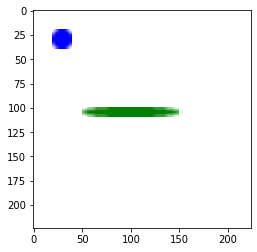

In [5]:
target_size = 20
reference_size = (10, 100)
reference_positions = [(105, 100)]

target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='blue')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='green')

blur_func = lambda x: cv2.blur(x, (5, 5))

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
gen = PatchStimulusGenerator(target_size, reference_size, target_patch, reference_patch,
                             blur_func=blur_func)
x = gen.generate((30, 30), reference_positions)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

In [6]:
every = 5
half_target = target_size // 2
row_max = DEFAULT_CANVAS_SIZE[0] - half_target
col_max = DEFAULT_CANVAS_SIZE[1] - half_target
target_positions = [(r * every, c * every) for r, c 
                    in itertools.product(range(half_target // every, row_max // every), 
                                         range(half_target // every, col_max // every))]

batch = gen.batch_generate(target_positions, reference_positions)
batch.shape

torch.Size([1600, 3, 224, 224])

In [7]:
miniature_stimuli_every = 20
row_max = DEFAULT_CANVAS_SIZE[0] - half_target
col_max = DEFAULT_CANVAS_SIZE[1] - half_target
miniature_target_positions = [(r * miniature_stimuli_every, c * miniature_stimuli_every) for r, c 
                                in itertools.product(range(1, 
                                                           row_max // miniature_stimuli_every + 1), 
                                                     range(1, 
                                                           col_max // miniature_stimuli_every + 1))]
# miniature_target_positions
miniature_batch = gen.batch_generate(miniature_target_positions, reference_positions)
miniature_batch.shape

torch.Size([100, 3, 224, 224])

## ImageNet-pretrained resnet18

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[1.        0.0341567]
 [0.0341567 1.       ]]


------

### t-SNE plots

Border colored by the column (horizontal position) of the target object

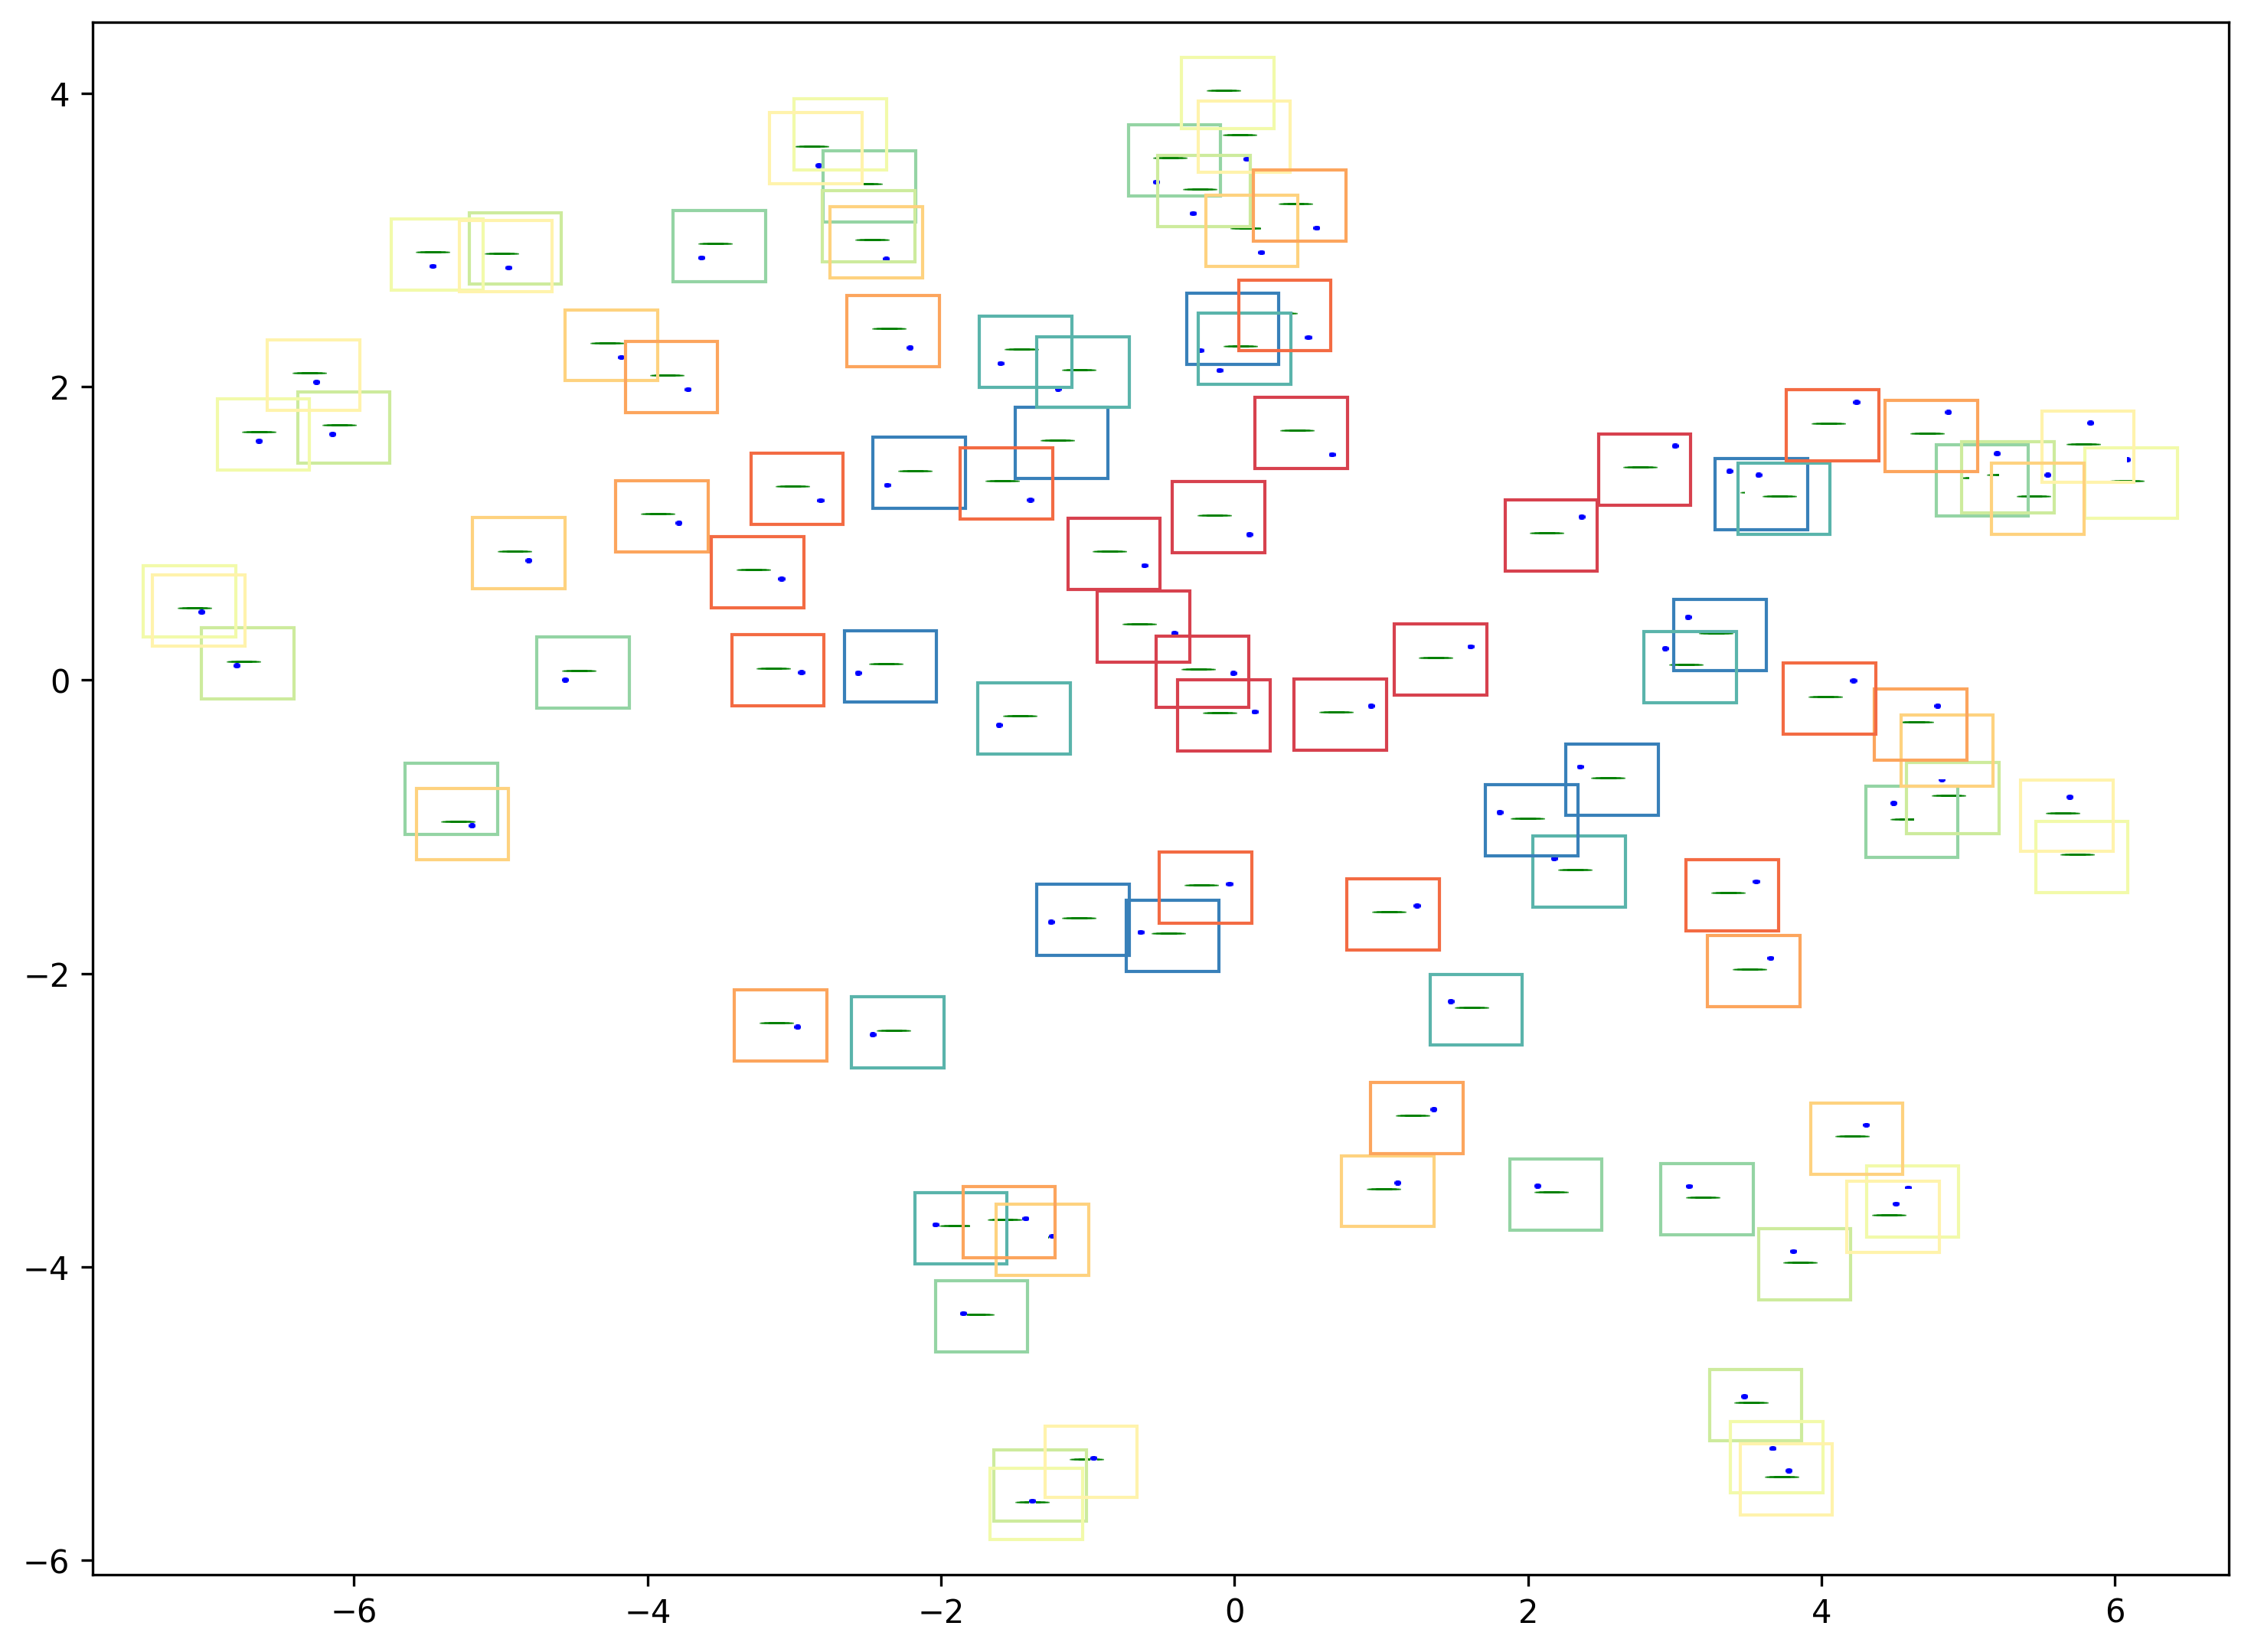

In [8]:
resnet = build_model(RESNET, device, pretrained=True)
# analyze_single_model('ImageNet-pretrained resnet18', resnet, gen, target_positions, reference_positions)
analyze_single_model('ImageNet-pretrained resnet18', resnet, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='column', figsize=(12, 12), dpi=300))
# analyze_single_model('ImageNet-pretrained resnet18', resnet, gen, target_positions, 
#                      reference_positions, plot_tsne_func=plot_tsne_quiver)
del resnet

## ImageNet-pretrained vgg

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[1.         0.00679218]
 [0.00679218 1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

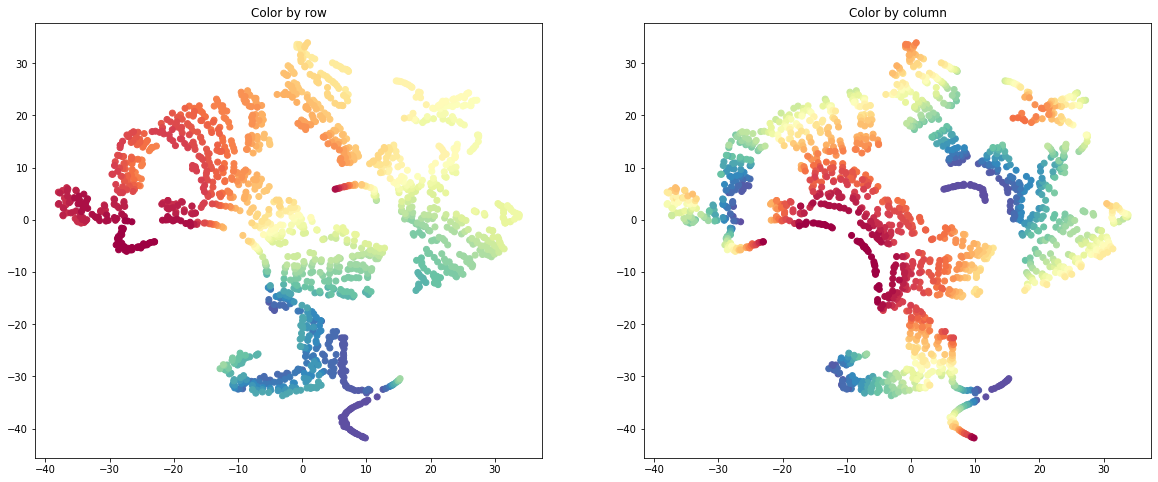

In [9]:
vgg = build_model(VGG, device, pretrained=True)
analyze_single_model('ImageNet-pretrained vgg', vgg, gen, target_positions, reference_positions)
del vgg

## ImageNet-pretrained mobilenet

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[1.         0.13184606]
 [0.13184606 1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

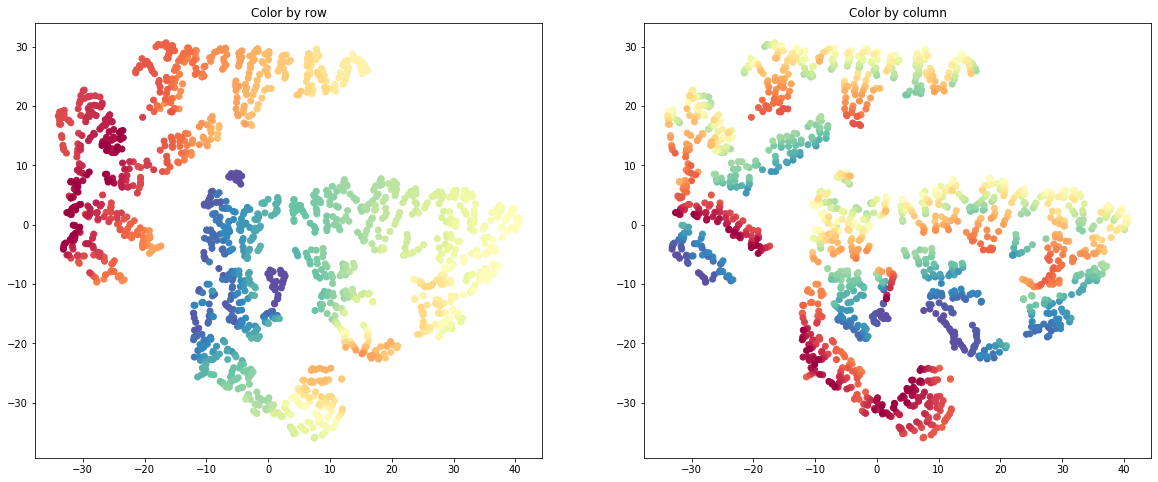

In [10]:
mobilenet = build_model(MOBILENET, device, pretrained=True)
analyze_single_model('ImageNet-pretrained mobilenet', mobilenet, gen, target_positions, reference_positions)
del mobilenet

## ImageNet-pretrained resnext50_32x4d

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[1.         0.08448506]
 [0.08448506 1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

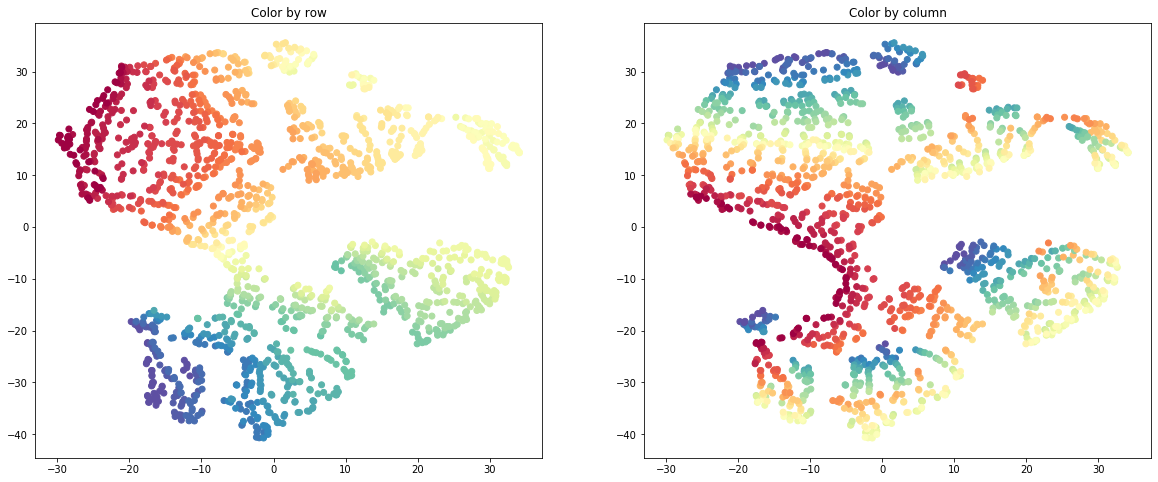

In [11]:
resnext50_32x4d = build_model(RESNEXT, device, pretrained=True)
analyze_single_model('ImageNet-pretrained resnext50_32x4d', resnext50_32x4d, gen, target_positions, reference_positions)
del resnext50_32x4d

## mobilenet-random-weights

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[1.         0.16976014]
 [0.16976014 1.        ]]


------

### t-SNE plots

Border colored by the row (vertical position) of the target object

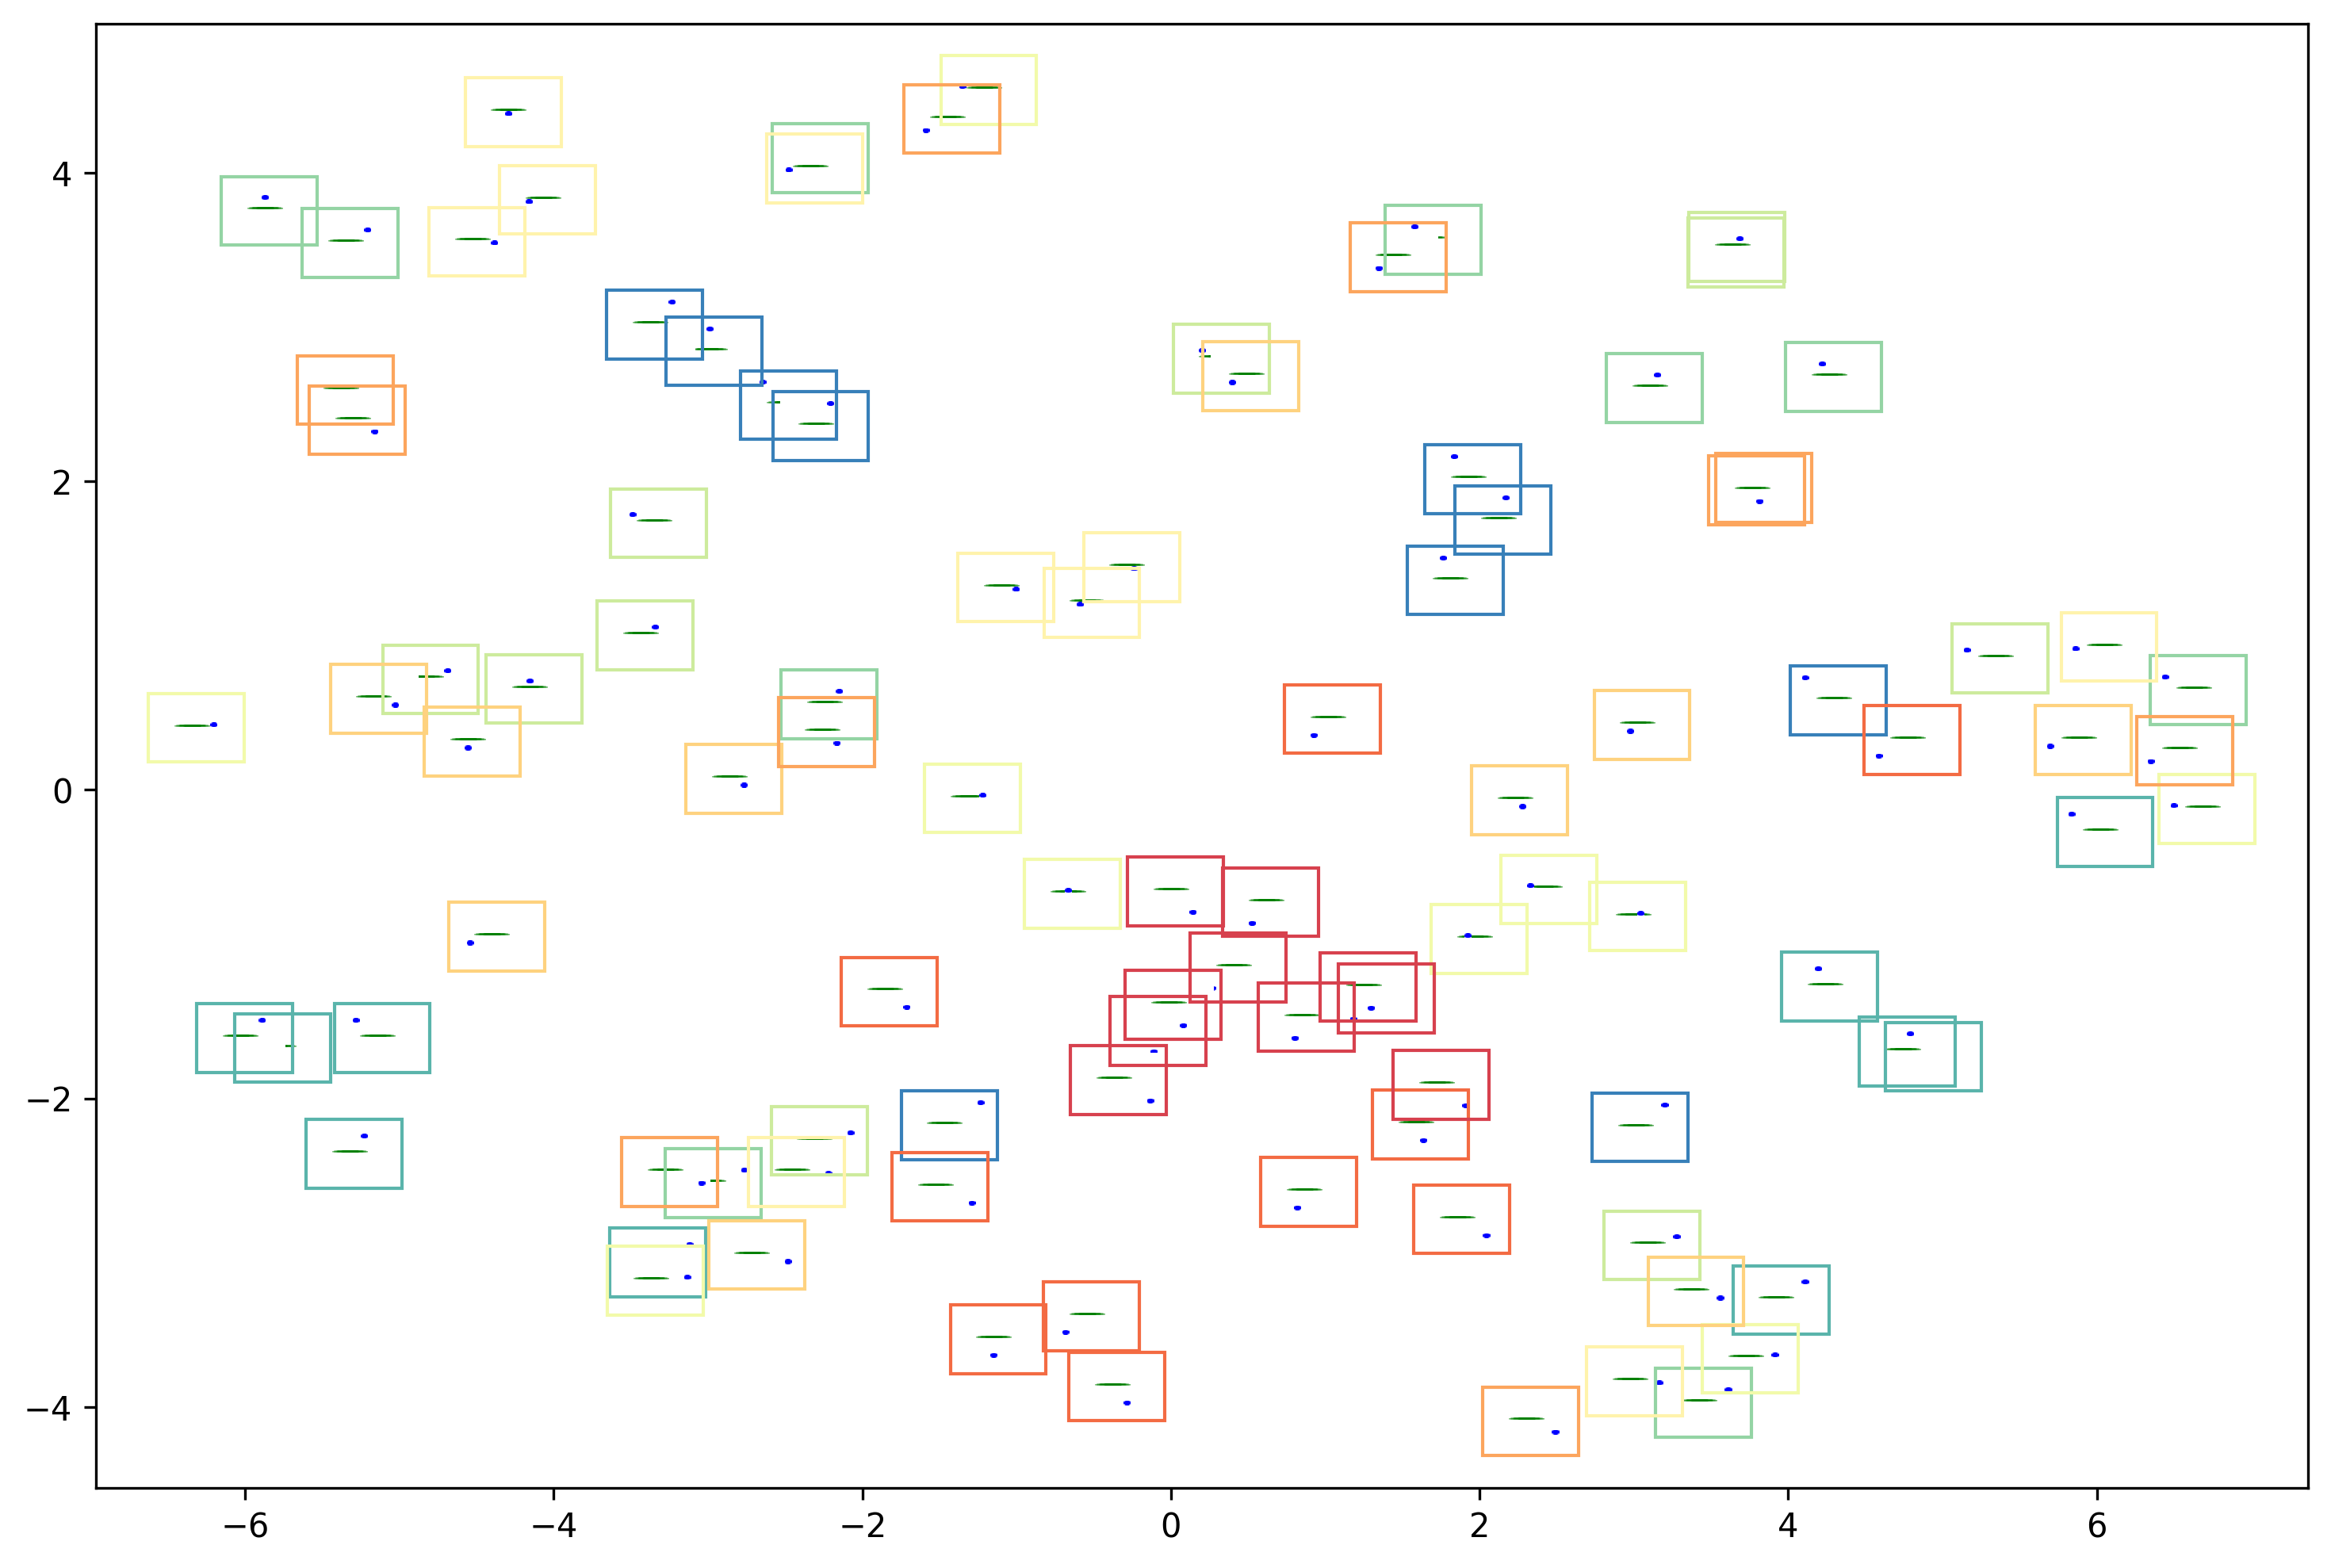

## mobilenet-random-weights

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[1.         0.16976014]
 [0.16976014 1.        ]]


------

### t-SNE plots

Border colored by the column (horizontal position) of the target object

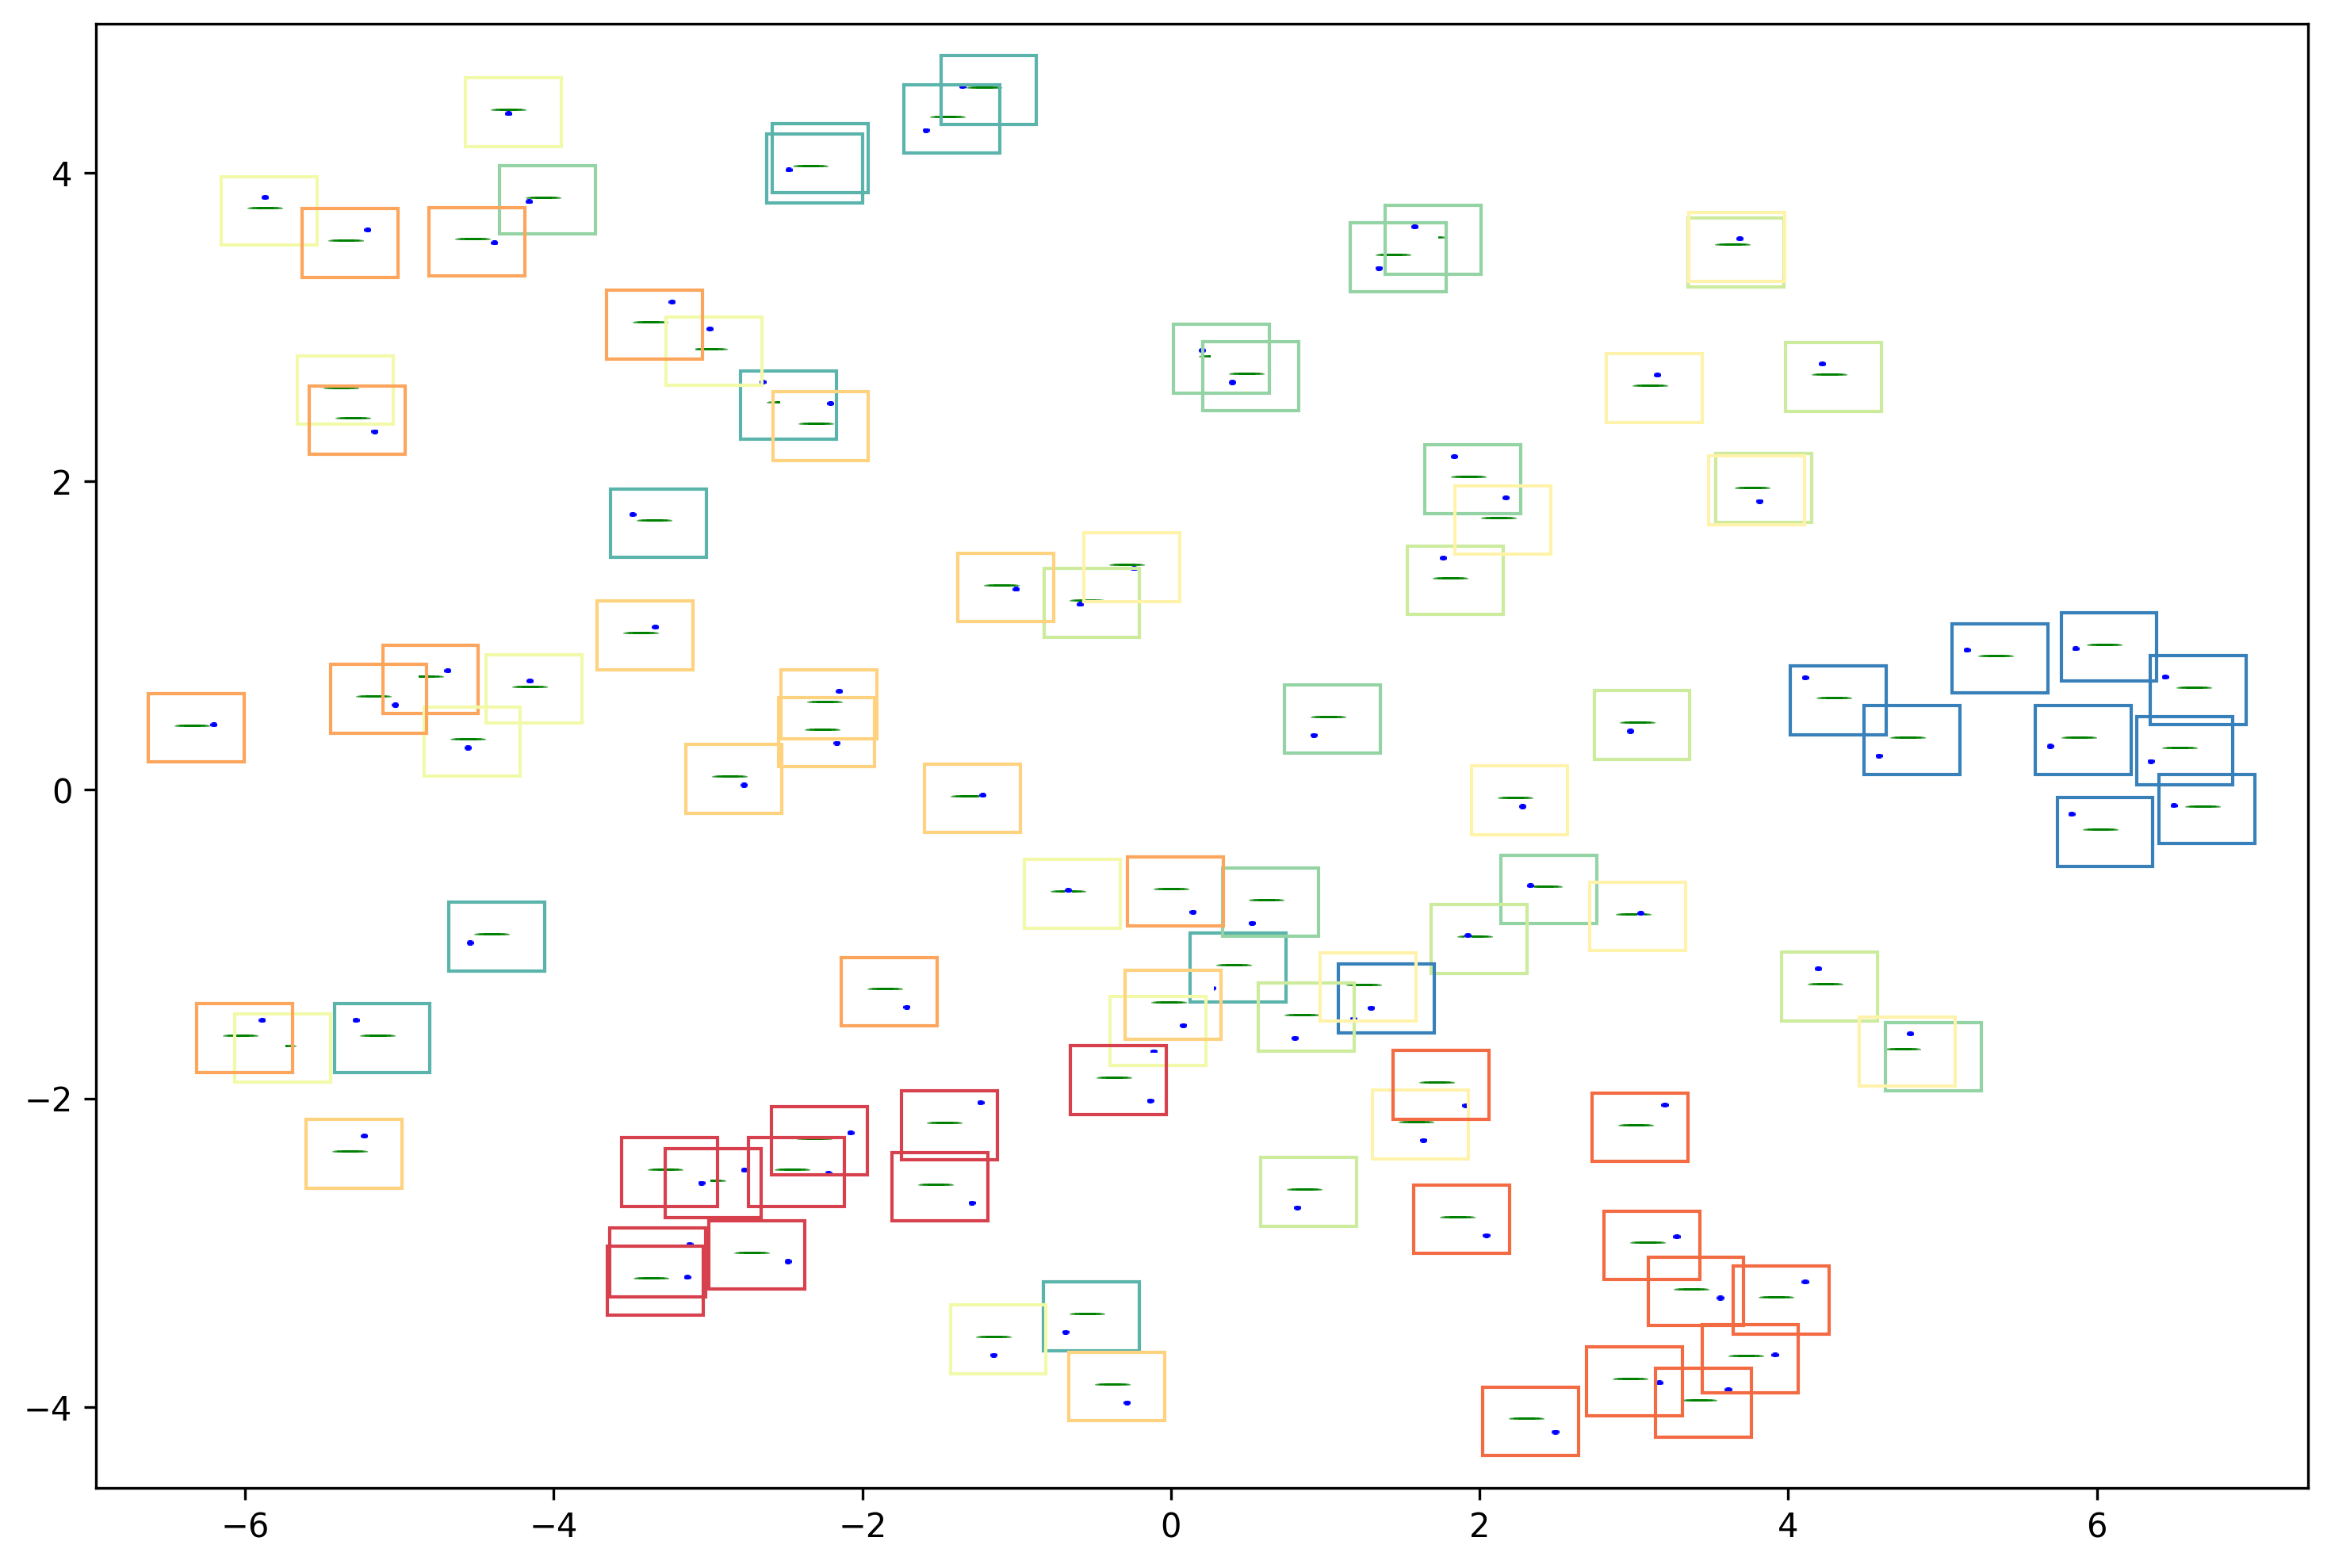

In [12]:
mobilenet_random_weights = build_model(MOBILENET, device, pretrained=False)

# analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, target_positions, reference_positions)
analyze_single_model('mobilenet-random-weights', mobilenet_random_weights, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='row', figsize=(12, 12), dpi=300))
# analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, target_positions, reference_positions,
#                      plot_tsne_func=plot_tsne_quiver)

analyze_single_model('mobilenet-random-weights', mobilenet_random_weights, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='col', figsize=(12, 12), dpi=300))

del mobilenet_random_weights

## TC-SAY-mobilenet

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.         -0.53158797]
 [-0.53158797  1.        ]]


------

### t-SNE plots

Border colored by the column (horizontal position) of the target object

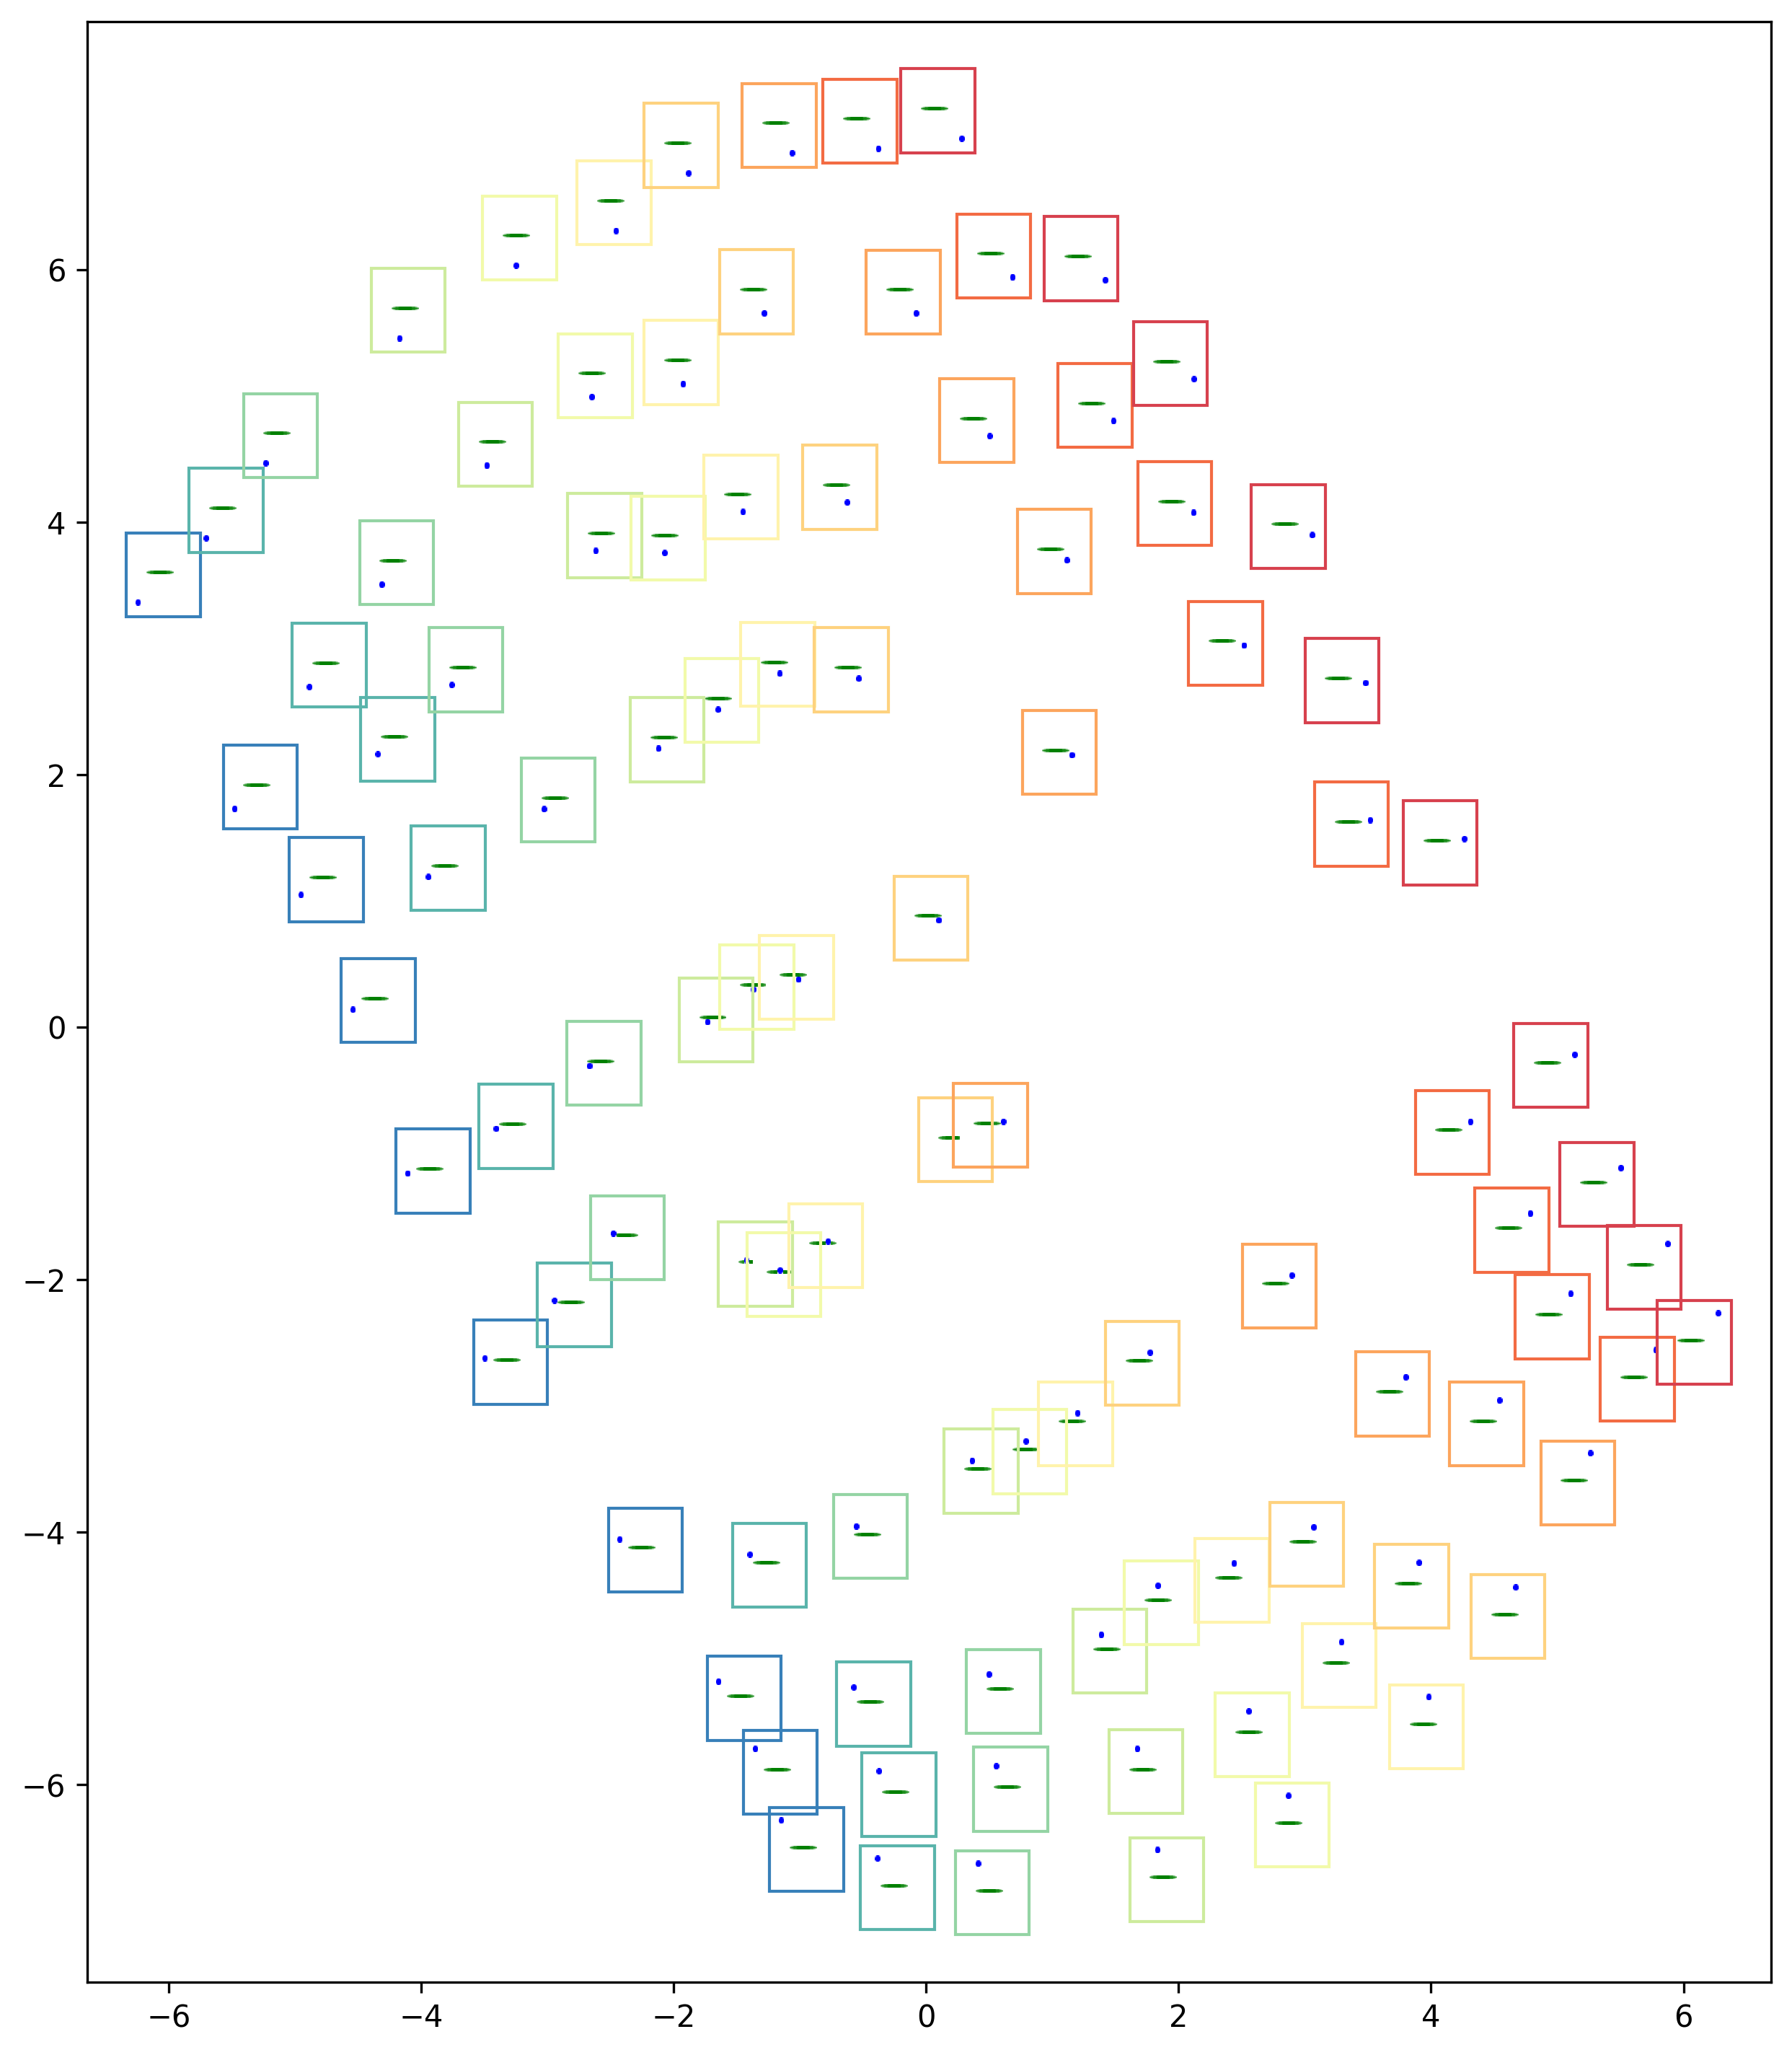

In [13]:
saycam_mobilenet = build_model(MOBILENET, device, pretrained=False, saycam='SAY')

# analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, target_positions, reference_positions)
analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, miniature_target_positions, 
                     reference_positions, plot_tsne_func=plot_tsne_miniature_stimuli, 
                     plot_kwargs=dict(stim_size_percent=0.04, border_width=0.5,
                                      color_border_by='col', figsize=(12, 12), dpi=300))
# analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, target_positions, reference_positions,
#                      plot_tsne_func=plot_tsne_quiver)


del saycam_mobilenet

## TC-S-mobilenet

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.         -0.58949897]
 [-0.58949897  1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

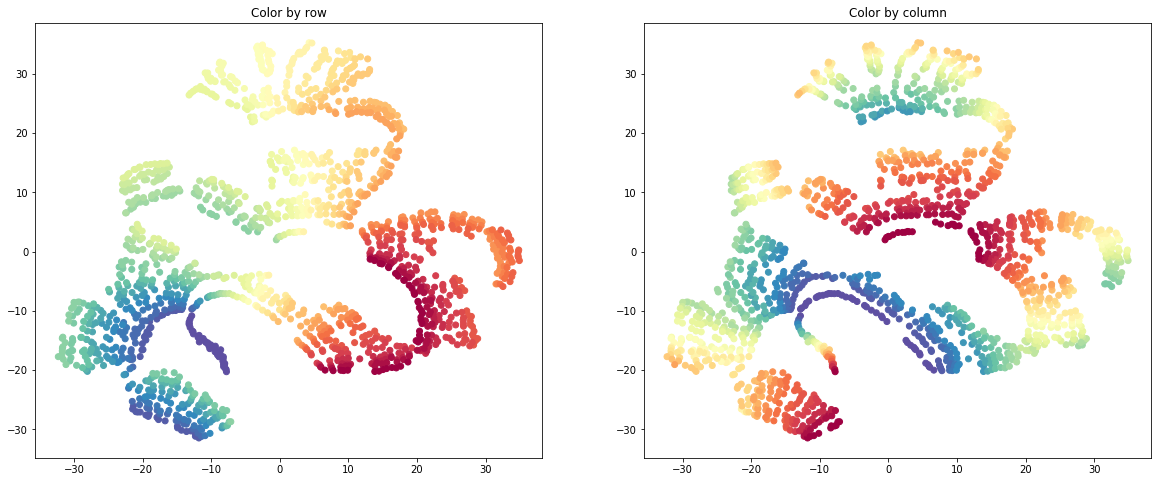

In [15]:
s_mobilenet = build_model(MOBILENET, device, pretrained=False, saycam='S')
analyze_single_model('TC-S-mobilenet', s_mobilenet, gen, target_positions, reference_positions)
del s_mobilenet

## TC-SAY-resnext

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.         -0.06804059]
 [-0.06804059  1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

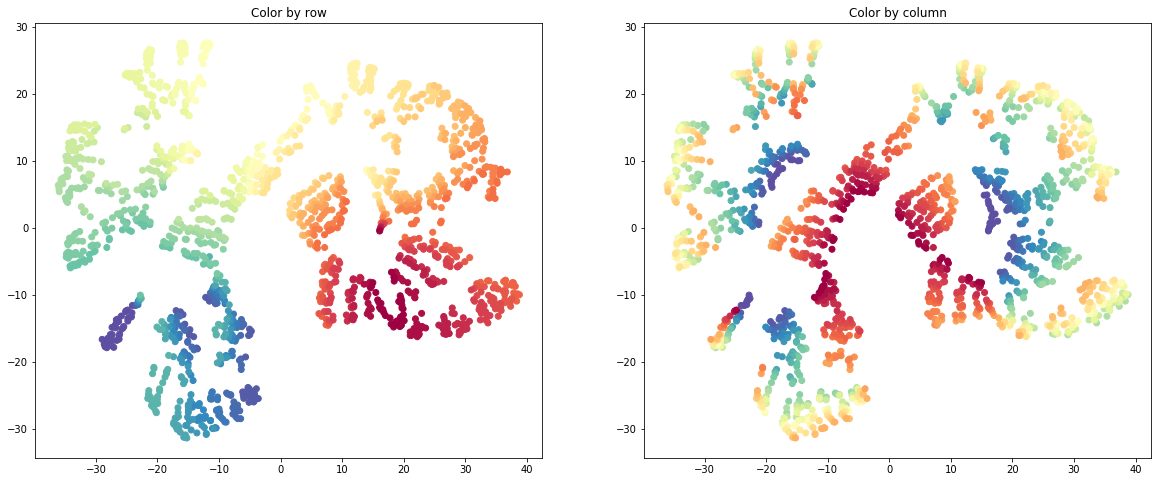

In [16]:
saycam_resnext50_32x4d = build_model(RESNEXT, device, pretrained=False, saycam='SAY')
analyze_single_model('TC-SAY-resnext', saycam_resnext50_32x4d, gen, target_positions, reference_positions)
del saycam_resnext50_32x4d

## TC-S-resnext

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.        -0.0420799]
 [-0.0420799  1.       ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

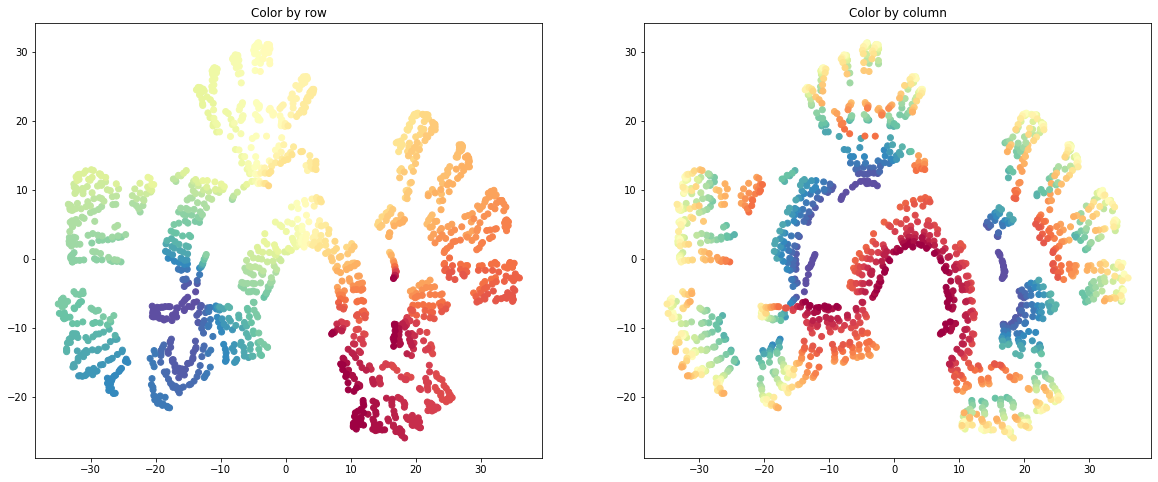

In [17]:
s_resnext50_32x4d = build_model(RESNEXT, device, pretrained=False, saycam='S')
analyze_single_model('TC-S-resnext', s_resnext50_32x4d, gen, target_positions, reference_positions)
del s_resnext50_32x4d